In [2]:
# --- imports ---
import time
import unittest
import numpy as np
import rospy
import bisect
from imitation_learning_ros_package.srv import SendRelCor
import src.sim.ros.python3_ros_ws.src.handcrafted_cone_detection.src.waypoint_extractor as wpx
import cv2
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
from IPython.display import clear_output


In [13]:
waypoint_extr = wpx.WaypointExtractor()

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.


ROSInitException: Failed to initialize time. Please check logs for additional details

In [3]:
#Using the 2d_location (SLOW) and the depth using triangulation
#for linear images
am_pics = 10
dual_pictures = np.linspace(1,am_pics,am_pics)
triang_coor_slow = []
im_coor_1 = [0, 0, 0]
im_coor_2 = [0, 0, 0]

start_time = time.time()
for img_idx in range(len(dual_pictures)):
    path_1 = '/home/thomas/code/imitation-learning-codebase/on_drone_rec_2/' + str(int(dual_pictures[img_idx])) + '_1.jpg'
    path_2 = '/home/thomas/code/imitation-learning-codebase/on_drone_rec_2/' + str(int(dual_pictures[img_idx])) + '_2.jpg'
    current_image_1 = cv2.imread(path_1, cv2.IMREAD_GRAYSCALE)
    current_image_2 = cv2.imread(path_2, cv2.IMREAD_GRAYSCALE)
    bin_im_1 = waypoint_extr.get_cone_binary(current_image_1, threshold=127)
    bin_im_2 = waypoint_extr.get_cone_binary(current_image_2, threshold=127)
    im_coor_1 = waypoint_extr.get_cone_2d_location(bin_im_1)# im_coor_1)
    im_coor_2 = waypoint_extr.get_cone_2d_location(bin_im_2)# im_coor_2)
    current_3d_coor = waypoint_extr.update_median(waypoint_extr.get_depth_triang(im_coor_1,im_coor_2))
    rotation_coordinates = np.array([waypoint_extr.x,waypoint_extr.y,waypoint_extr.z])
    triang_coor_slow.append(rotation_coordinates)
print(time.time()-start_time)

0.15590310096740723
shutdown request: [/waypoint_extractor_server] Reason: new node registered with same name


In [3]:
    def transform_coordinates(point: np.ndarray,
                  orientation: np.ndarray = np.eye(3),
                  translation: np.ndarray = np.zeros((3,)),
                  invert: bool = False) -> np.ndarray:
        transformation = np.zeros((4, 4))
        transformation[0:3, 0:3] = orientation
        transformation[0:3, 3] = translation
        transformation[3, 3] = 1
        point = np.concatenate([point, np.ones(1,)])
        if invert:
            transformation = np.linalg.inv(transformation)
        return np.matmul(transformation, point)

In [4]:
 def get_translations():
            translations = []
            translations_time = []
            with open('/home/thomas/code/imitation-learning-codebase/transform_data/translation_data.txt') as f:
                lines = f.readlines()
                first_line = True
                for line in lines:
                    line = line.strip()
                    if line:
                        if first_line:
                            columns = [item.strip() for item in line.split(',')]
                            first_line = False
                        else:
                            if len(translations) == 0:
                                data = [item.strip() for item in line.split(',')]
                                ref_translation = ([float(data[1]),float(data[2]),float(data[3])])
                                ref_time = int(data[0])
                            data = [item.strip() for item in line.split(',')]
                            translations_time.append(int(data[0])-ref_time)
                            translations.append([float(data[1])-ref_translation[0], float(data[2])-ref_translation[1], float(data[3])-ref_translation[2]])
            return translations, translations_time

In [5]:
    def get_rotations():
        rotations = []
        rotations_time = []
        with open('/home/thomas/code/imitation-learning-codebase/transform_data/rotations.txt') as f:
            lines = f.readlines()
            first_line = True
            for line in lines:
                line = line.strip()
                if line:
                    if first_line:
                        columns = [item.strip() for item in line.split(',')]
                        first_line = False
                    else:
                        if len(rotations) == 0:
                            data = [item.strip() for item in line.split(',')]
                            ref_time = int(data[0])
                        data = [item.strip() for item in line.split(',')]
                        rotations_time.append(int(data[0])-ref_time)
                        rotations.append([float(data[1]), float(data[2]), float(data[3]), float(data[4])])
        return  rotations, rotations_time

In [6]:
translation_matrix, translation_times = get_translations()
rot_m, rotation_times = get_rotations()

In [7]:
def get_pic_times():
        pic_times_ns = []
        seconds = ''
        with open('/home/thomas/code/imitation-learning-codebase/transform_data/timestamps_pics.txt') as f:
            lines = f.readlines()
            for line in lines:
                line = line.strip()
                if line:
                    if seconds == '':
                        data = [item.strip() for item in line.split(' ')]
                        ref_time_s = data[1]
                    if len(pic_times_ns) == 0:
                        data = [item.strip() for item in line.split(' ')]
                        ref_time_ns = int(ref_time_s + data[1])
                    data = [item.strip() for item in line.split(' ')]
                    if len(data) >1:
                        if data[0] == 'secs:':
                            seconds = data[len(data)-1]
                        else:
                            pic_times_ns.append(int(seconds + data[len(data)-1])-ref_time_ns)
                            
        return  pic_times_ns

In [8]:
def get_nearest_stamp_idx(time_stamp,time_list,start_idx,total_len):
    index = start_idx
    while time_stamp > time_list[index]:
        index+=1
    return index

In [9]:
pic_time_ns = get_pic_times()
translation_synchronised = []
rotation_synchronised = []
start_index_translation = 0
start_index_rotation = 0
for pic_time in pic_time_ns:
    start_index_translation = get_nearest_stamp_idx(pic_time,translation_times,start_index_translation,len(pic_time_ns)-1)
    start_index_rotation = get_nearest_stamp_idx(pic_time,rotation_times,start_index_rotation,len(pic_time_ns)-1)
    translation_synchronised.append(translation_matrix[start_index_translation])
    rotation_synchronised.append(rot_m[start_index_rotation])

Text(0, 0.5, 'y ax')

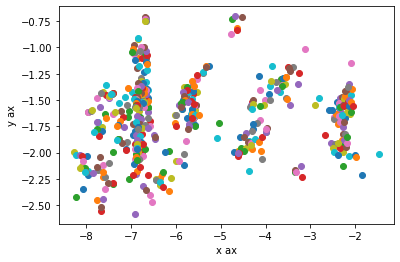

In [28]:
fig = plt.figure()
ax = fig.add_subplot()#111, projection = '3d')
global_coor = []
for img_idx in range(0, 499):
    rot_mat = R.from_quat(rotation_synchronised[img_idx])
    translation = translation_synchronised[img_idx+1]
    rotation_coordinates = nn_estimations[img_idx]
    if rotation_coordinates[0] < 5:
        rotated_coor = transform_coordinates(rotation_coordinates, orientation = rot_mat.as_matrix(), translation = translation)
        global_coor.append(rotated_coor)
        ax.scatter(global_coor[len(global_coor)-1][0], global_coor[len(global_coor)-1][2])#, global_coor[len(global_coor)-1][2])
#ax.set_xlim(-10,3)
#ax.set_ylim(-3,8)
ax.set_xlabel("x ax")
ax.set_ylabel("y ax")


In [12]:
from numpy import genfromtxt
path_csv = '/home/thomas/code/imitation-learning-codebase/notebooks/data_nn.csv'
nn_estimations = genfromtxt(path_csv, delimiter=',')


In [32]:
print(triang_coor_slow[54])

[ 1.408       0.34461538 -1.41784615]


Text(0.5, 0, 'y ax')

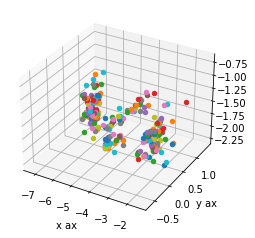

In [22]:
#speedup
fig = plt.figure()
ax = fig.add_subplot()#111), projection = '3d')
global_coor = []
for img_idx in range(0, 250):
    rot_mat = R.from_quat(rotation_synchronised[img_idx])
    translation = translation_synchronised[img_idx]
    rotation_coordinates = nn_estimations[img_idx]
    if rotation_coordinates[0] >0 and rotation_coordinates[0] < 4:
        rotated_coor = transform_coordinates(rotation_coordinates, orientation = rot_mat.as_matrix(), translation = translation)
        global_coor.append(rotated_coor)
    
        ax.scatter(global_coor[len(global_coor)-1][0], global_coor[len(global_coor)-1][1], global_coor[len(global_coor)-1][2])
#ax.set_xlim(-8,1)
#ax.set_ylim(-1,7)
ax.set_xlabel("x ax")
ax.set_ylabel("y ax")

#with open('demo_speedup.txt', 'w') as f:
#    for index_array in range(len(global_coor)):
#        f.write("%f %f %f \n" % (global_coor[index_array][0],global_coor[index_array][1],global_coor[index_array][2]))


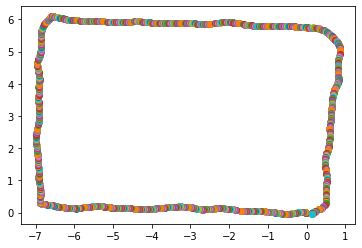

In [26]:
#plot of the translation matrix.
fig = plt.figure()
ax = fig.add_subplot()#111, projection = '3d')
global_coor = []
for img_idx in range(0, 1270):
    rot_mat = R.from_quat(rotation_synchronised[img_idx])
    translation = translation_synchronised[img_idx+1]
    rotation_coordinates = np.array([0,0,0])
    rotated_coor = transform_coordinates(rotation_coordinates, rot_mat.as_matrix(),translation)
    global_coor.append(rotated_coor)
    
    ax.scatter(global_coor[len(global_coor)-1][0], global_coor[len(global_coor)-1][1])#, global_coor[len(global_coor)-1][2])
#ax.set_xlim3d(-8,1)
#ax.set_ylim3d(-1,8)
#ax.set_zlim3d(-1,1)
#ax.set_xlabel("x ax")
#ax.set_ylabel("y ax")
#ax.set_zlabel("z ax")

In [25]:
# Test for data generation
# Transformation of locations to annotations
def generate_annotation_cone( position):
    
    distance = position[0]**2+ position[1]**2+ position[2]**2
    yaw = position[5]
    roll = position[3]
    pitch = position[4]
    x = -np.cos(yaw)  * position[0] * np.cos(pitch) + np.sin(yaw)  * position[1] - np.sin(pitch) * position[2]
    y = -np.cos(yaw)  * position[1] * np.cos(roll)  - np.sin(yaw)  * position[0] - np.sin(roll)  * position[2]
    z = -np.cos(pitch)* position[2] * np.cos(roll)  - np.sin(pitch)* position[0] - np.sin(roll)  * position[1]
    return np.array([x, y, z])

def test_generate_annotation_cone(position):
    annotations = generate_annotation_cone(position)
    print(annotations)

roll  = 0
pitch = np.pi/2 
yaw   = 0
position = np.array([0, 0, 0, roll, pitch, yaw])
test_generate_annotation_cone(position)

[ 0. -0. -0.]


In [24]:
def rotations(position):
    yaw = position[5]
    roll = position[3]
    pitch = position[4]
    
    rotation_roll = np.array([[1,0,0],[0,np.cos(roll),-1*np.sin(roll)],[0,np.sin(roll),np.cos(roll)]])

    rotation_pitch = np.array([[np.cos(pitch),0,np.sin(pitch)],[0,1,0],[-1*np.sin(pitch),0,np.cos(pitch)]])

    rotation_yaw = np.array([[np.cos(yaw),-1*np.sin(yaw),0],[np.sin(yaw),np.cos(yaw),0],[0,0,1]])
    rotationmatrix =np.matmul(np.matmul(rotation_roll,rotation_pitch),rotation_yaw)
    coordin_in = np.array([-1*position[0],-1*position[1],-1*position[2]])
    coordin_out = coordin_in.dot(rotationmatrix)
    return coordin_out
position = np.array([0,0,0,0,0,np.pi/2])
print(rotations(position))

[0. 0. 0.]
